# Import libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import streamlit as st
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,classification_report


# Load dataset

In [2]:
df=pd.read_csv("C:/Users/VICTUS/Downloads/cleaned_movie_data.csv")

# Visualization of the movie dataset

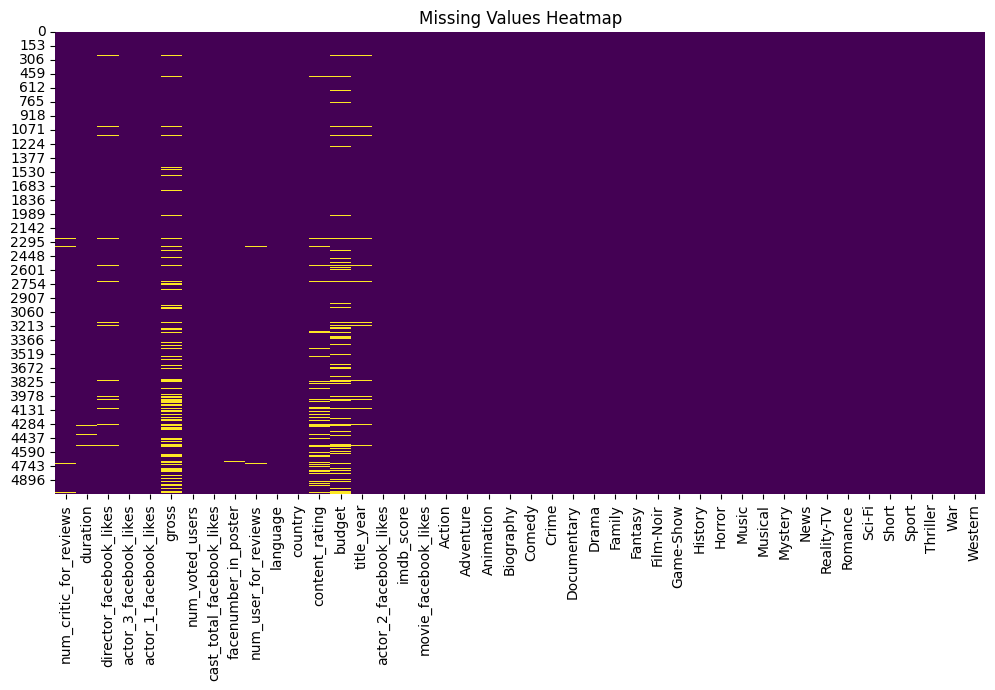

In [3]:
# 1. Missing Values Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

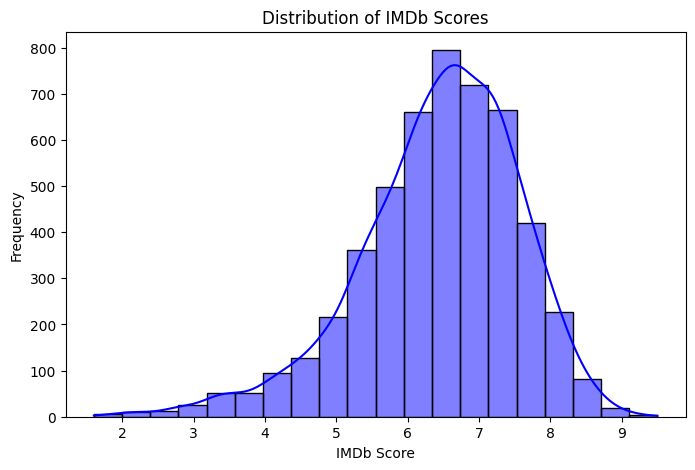

In [4]:
# 2. Distribution of IMDb Scores
plt.figure(figsize=(8, 5))
sns.histplot(df["imdb_score"], bins=20, kde=True, color="blue")
plt.title("Distribution of IMDb Scores")
plt.xlabel("IMDb Score")
plt.ylabel("Frequency")
plt.show()

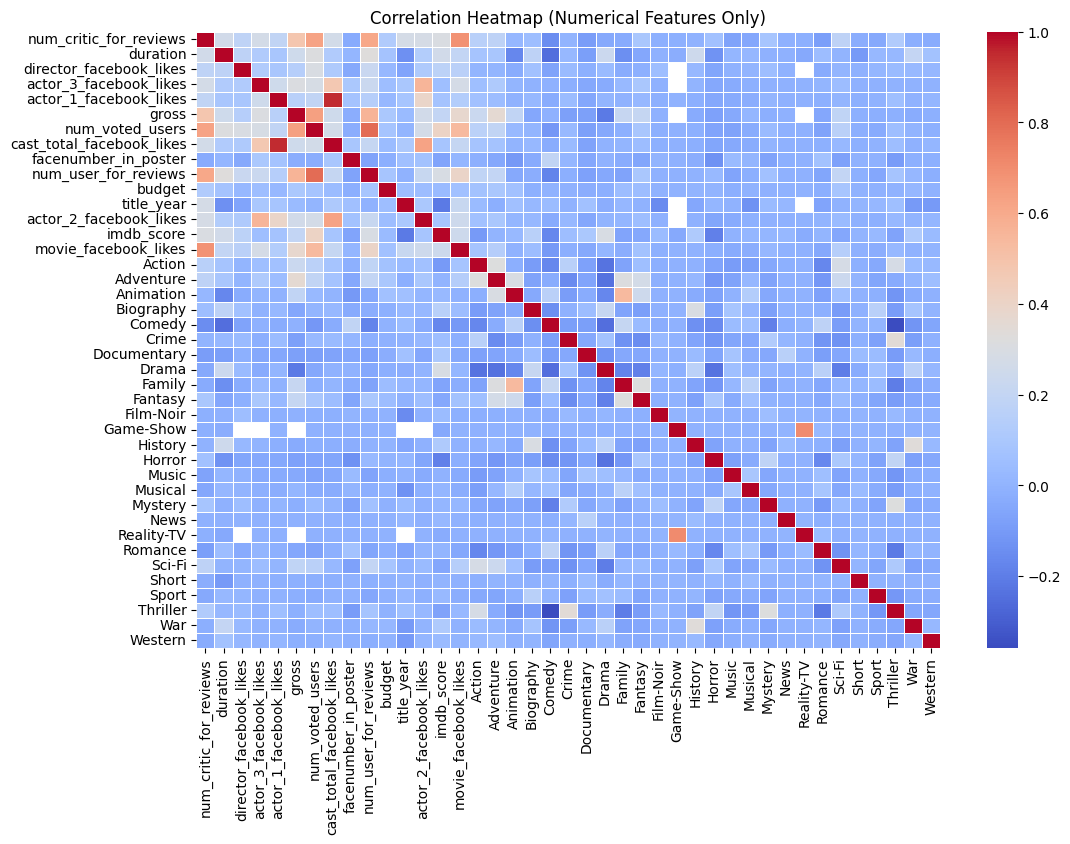

In [5]:
# 3. Correlation Heatmap (for numerical variables)
# Select only numerical columns for correlation
numeric_df = df.select_dtypes(include=["number"])

# Generate the correlation matrix again
plt.figure(figsize=(12, 8))
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap (Numerical Features Only)")
plt.show()

Top 10 Most Common Genres:
 Drama        2594
Comedy       1872
Thriller     1411
Action       1153
Romance      1107
Adventure     923
Crime         889
Sci-Fi        616
Fantasy       610
Horror        565
dtype: int64


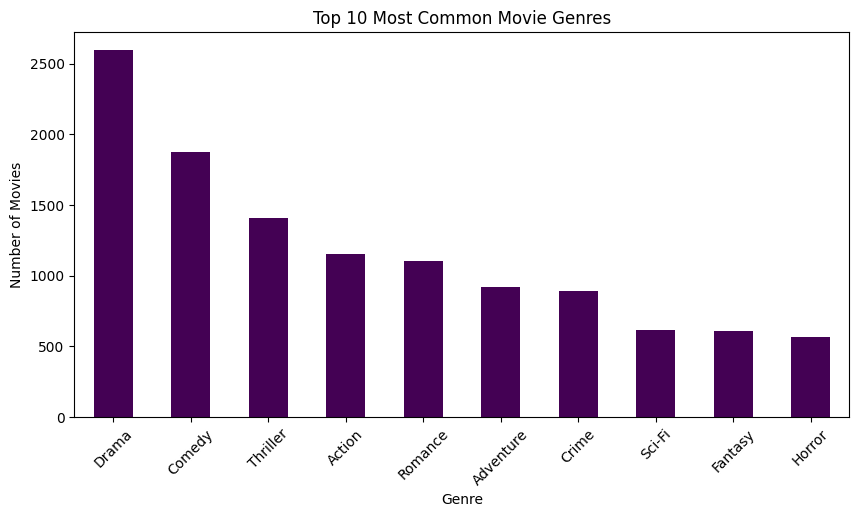

In [6]:
# 4. Top 10 Most Common Genres

# Exclude non-genre columns
exclude_columns = ["classify"]  # List of columns to exclude
genre_columns = [col for col in df.columns if col not in exclude_columns and df[col].nunique() == 2]
# Sum occurrences of each genre across all movies
genre_counts = df[genre_columns].sum().sort_values(ascending=False)
# Get the Top 10 most common genres
top_10_genres = genre_counts.head(10)

# Print Top 10 genres
print("Top 10 Most Common Genres:\n", top_10_genres)

# Plot bar chart
plt.figure(figsize=(10, 5))
top_10_genres.plot(kind='bar', colormap="viridis")
plt.title("Top 10 Most Common Movie Genres")
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.xticks(rotation=45)
plt.show()


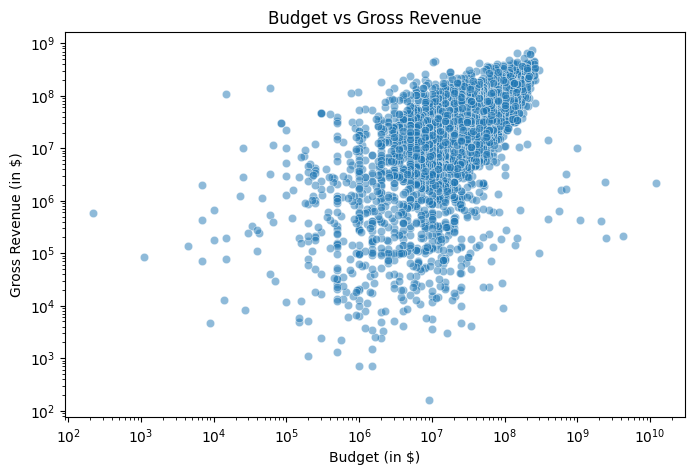

In [7]:
# 5. Budget vs Gross Revenue (Scatter Plot)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["budget"], y=df["gross"], alpha=0.5)
plt.title("Budget vs Gross Revenue")
plt.xlabel("Budget (in $)")
plt.ylabel("Gross Revenue (in $)")
plt.xscale("log")
plt.yscale("log")
plt.show()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   num_critic_for_reviews     4993 non-null   float64
 1   duration                   5028 non-null   float64
 2   director_facebook_likes    4939 non-null   float64
 3   actor_3_facebook_likes     5020 non-null   float64
 4   actor_1_facebook_likes     5036 non-null   float64
 5   gross                      4159 non-null   float64
 6   num_voted_users            5043 non-null   int64  
 7   cast_total_facebook_likes  5043 non-null   int64  
 8   facenumber_in_poster       5030 non-null   float64
 9   num_user_for_reviews       5022 non-null   float64
 10  language                   5029 non-null   object 
 11  country                    5038 non-null   object 
 12  content_rating             4740 non-null   object 
 13  budget                     4551 non-null   float

# Check the Missing value

In [9]:
df.isnull().sum()

num_critic_for_reviews        50
duration                      15
director_facebook_likes      104
actor_3_facebook_likes        23
actor_1_facebook_likes         7
gross                        884
num_voted_users                0
cast_total_facebook_likes      0
facenumber_in_poster          13
num_user_for_reviews          21
language                      14
country                        5
content_rating               303
budget                       492
title_year                   108
actor_2_facebook_likes        13
imdb_score                     0
movie_facebook_likes           0
Action                         0
Adventure                      0
Animation                      0
Biography                      0
Comedy                         0
Crime                          0
Documentary                    0
Drama                          0
Family                         0
Fantasy                        0
Film-Noir                      0
Game-Show                      0
History   

# Handle the Missing value

In [10]:
# Label Encoding for Categorical Variables
categorical_cols = df.select_dtypes(include=['object']).columns
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])


df.fillna(df.median(numeric_only=True), inplace=True)  # Fill numeric columns with median
df.isnull().sum()


num_critic_for_reviews       0
duration                     0
director_facebook_likes      0
actor_3_facebook_likes       0
actor_1_facebook_likes       0
gross                        0
num_voted_users              0
cast_total_facebook_likes    0
facenumber_in_poster         0
num_user_for_reviews         0
language                     0
country                      0
content_rating               0
budget                       0
title_year                   0
actor_2_facebook_likes       0
imdb_score                   0
movie_facebook_likes         0
Action                       0
Adventure                    0
Animation                    0
Biography                    0
Comedy                       0
Crime                        0
Documentary                  0
Drama                        0
Family                       0
Fantasy                      0
Film-Noir                    0
Game-Show                    0
History                      0
Horror                       0
Music   

# Handle Duplicate value

In [11]:
df.drop_duplicates(inplace=True)

# Outliers find

In [12]:
# Function to check outliers in all numerical columns
def count_outlier_columns(df):
    outlier_columns = []
    for col in df.select_dtypes(include=['number']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        if not outliers.empty:
            outlier_columns.append(col)
    return outlier_columns

# Get columns with outliers
outlier_cols = count_outlier_columns(df)
print("Columns with outliers:", outlier_cols)


Columns with outliers: ['num_critic_for_reviews', 'duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross', 'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster', 'num_user_for_reviews', 'language', 'country', 'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes', 'imdb_score', 'movie_facebook_likes', 'Action', 'Adventure', 'Animation', 'Biography', 'Crime', 'Documentary', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'War', 'Western']


# Outliers Visualization ( Box Plot)

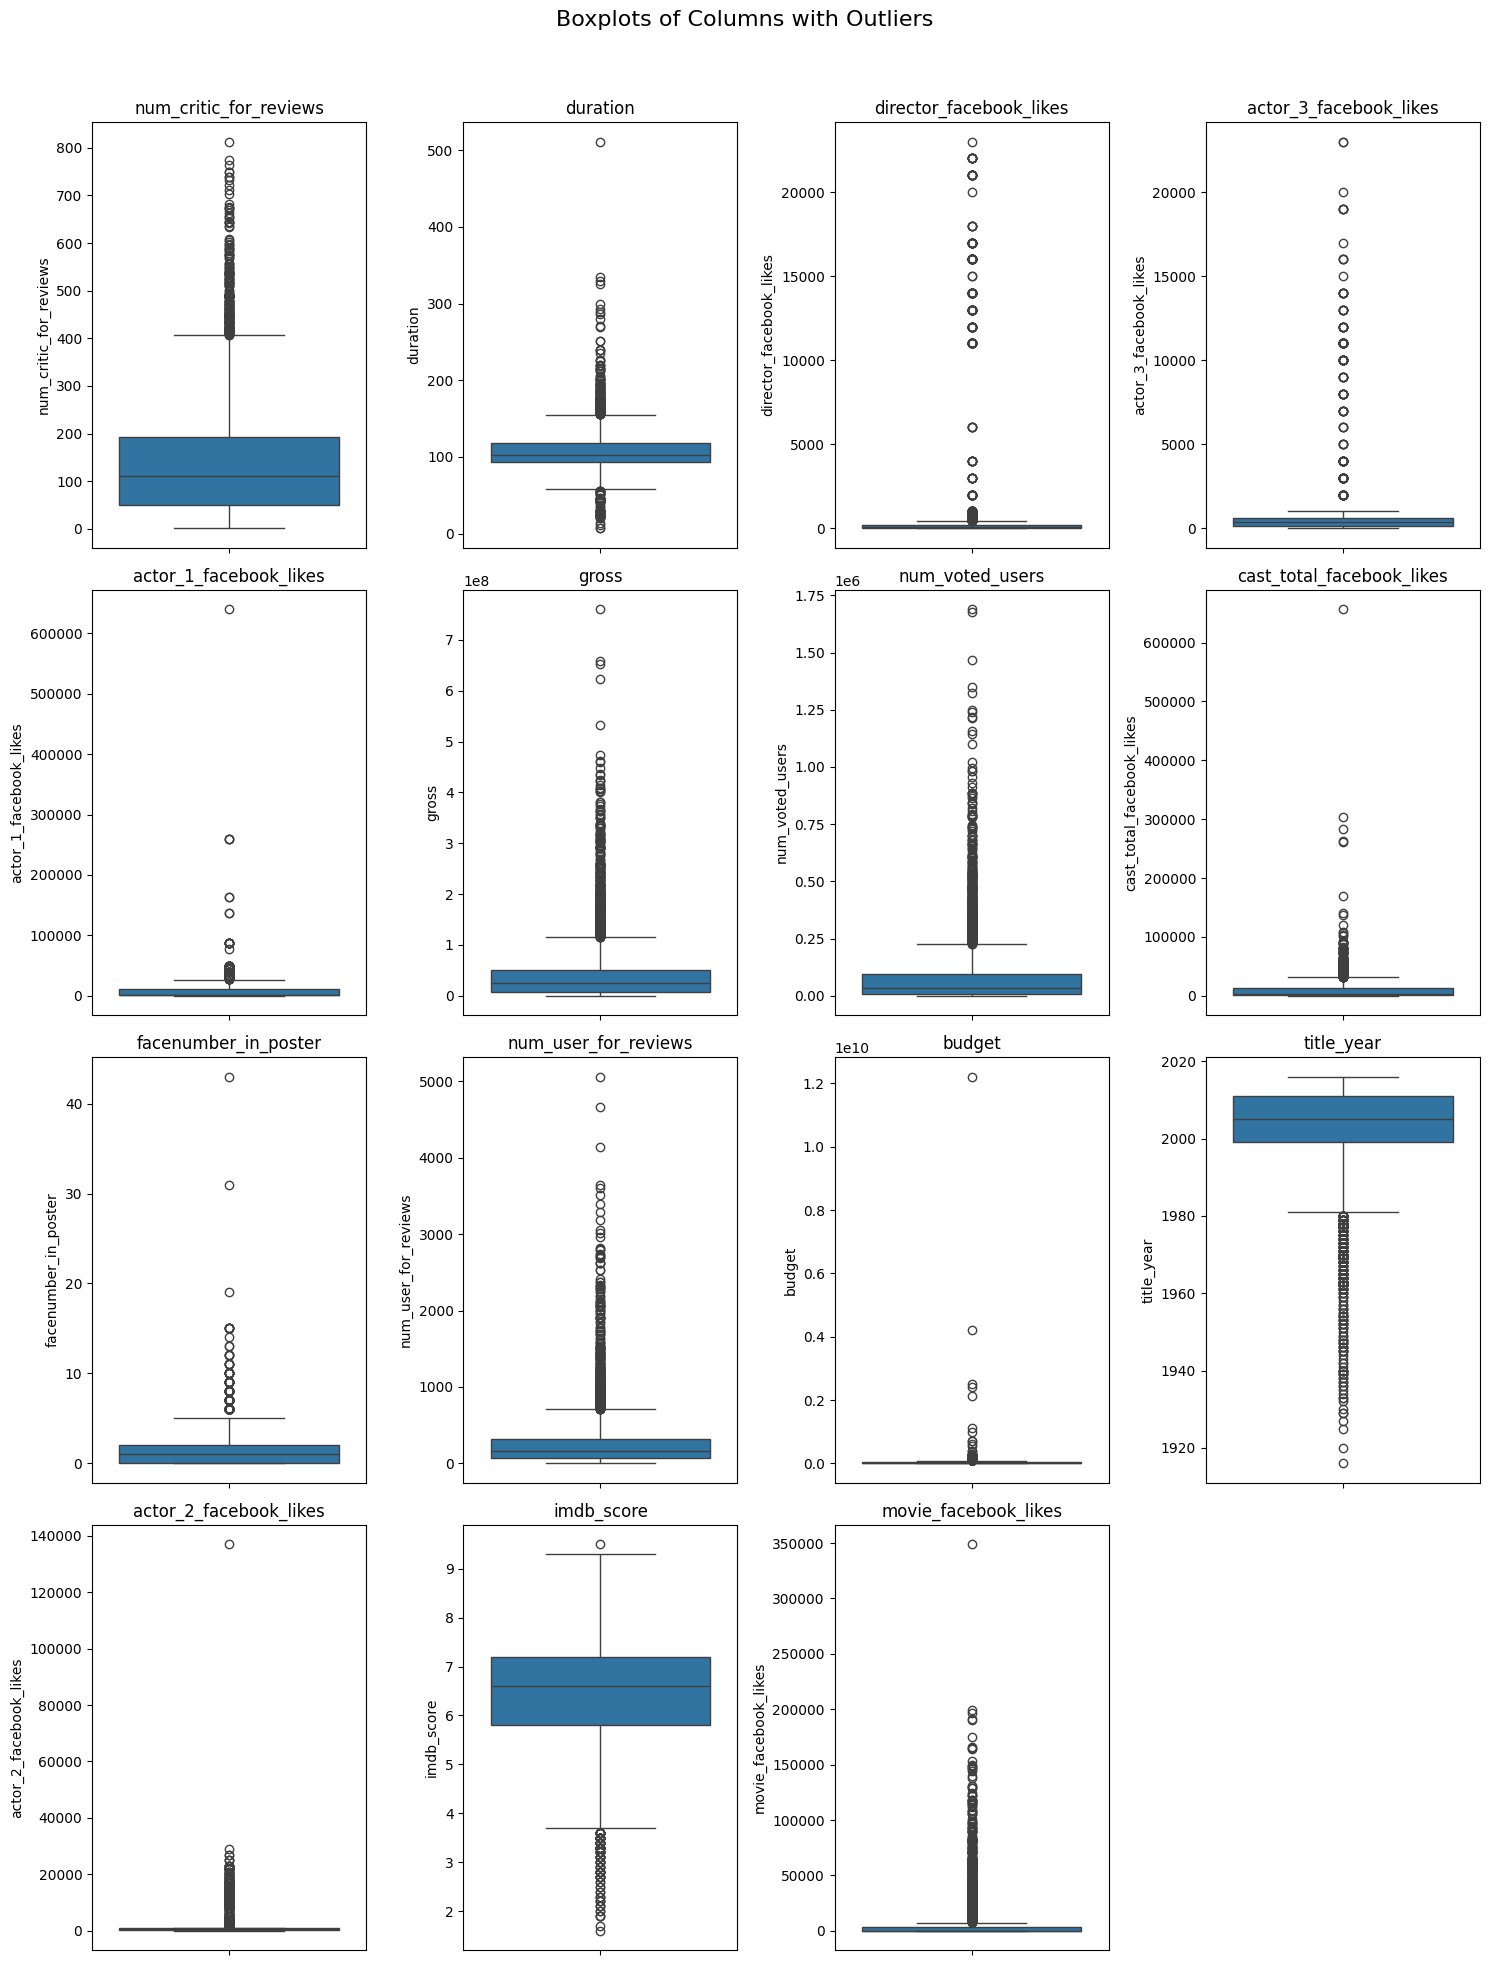

(4998, 44)

In [13]:
# Specified columns containing outliers
outlier_columns = [
    'num_critic_for_reviews', 'duration', 'director_facebook_likes',
    'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
    'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster',
    'num_user_for_reviews', 'budget', 'title_year', 'actor_2_facebook_likes',
    'imdb_score', 'movie_facebook_likes'
]

# Set up the figure
plt.figure(figsize=(15, 20))
plt.suptitle("Boxplots of Columns with Outliers", fontsize=16)

# Create boxplots for each column
for i, col in enumerate(outlier_columns):
    plt.subplot(4, 4, i+1)
    sns.boxplot(y=df[col])
    plt.title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
df.shape

# Outliers Remove

In [14]:
# Function to remove outliers using the IQR method
def remove_outliers_iqr(data, columns):
    df_clean = data.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# Remove outliers
df_cleaned = remove_outliers_iqr(df, outlier_columns)

# Display the shape before and after removing outliers
df.shape, df_cleaned.shape


((4998, 44), (1756, 44))

### Categorizing IMDb Scores into  ( 0-3 = "Flop", 3-6 = "Average",7-10 = "Hit" )

In [15]:

def categorize_imdb(score):
    if 1 <= score < 3:
        return "Flop"
    elif 3 <= score < 6:
        return "Average"
    else:
        return "Hit"

In [16]:
# it will store all value of imdb_score in new column Classify
df['Classify'] = df['imdb_score'].apply(categorize_imdb)

In [17]:
# Convert categories to numerical values (Flop = 0, Average = 1, Hit = 2)
df['Classify'] = df['Classify'].map({"Flop": 0, "Average": 1, "Hit": 2})

# train test Split

In [18]:
X_data = df.drop(columns=['Classify'])
# train test split ( 80% data training and 20% data testing )
X_train, X_test, y_train, y_test = train_test_split(
    X_data, df['Classify'], test_size=0.2, random_state=42
)

### Scale Features (Standardization)

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# it all the check for better accuracy ( Cross Validation )

In [20]:
# Hyperparameter Tuning for Random Forest 
# This dictionary (param_grid) is used for hyperparameter tuning in GridSearchCV for a Random Forest Classifier
param_grid = {

    # Number of decision trees in the random forest
    'n_estimators': [100, 200, 300],

    # Maximum depth of each tree. means depth 10,20
    'max_depth': [None, 10, 20],

    # Minimum number of samples required to split a node ( must have at least 2, 5, or 10 samples before splitting )
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

best_rf_model = grid_search.best_estimator_

# load Models

In [ ]:
# Define all models
models = {
    "Random Forest": best_rf_model,
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    
    
}

# Train and evaluate models

In [33]:
results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Confusion Matrix": conf_matrix,
        "Classification Report": report
    }



C:\Users\VICTUS\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\VICTUS\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\VICTUS\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [34]:
# Print results
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall: {metrics['Recall']:.4f}")
    print(f"F1 Score: {metrics['F1 Score']:.4f}")
    print("Confusion Matrix:\n", metrics["Confusion Matrix"])
    print("Classfication Report:\n",metrics["Classification Report"])


Model: KNN
Accuracy: 0.8290
Precision: 0.8202
Recall: 0.8290
F1 Score: 0.8235
Confusion Matrix:
 [[  0   4   1]
 [  0 180 101]
 [  0  65 649]]
Classfication Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.72      0.64      0.68       281
           2       0.86      0.91      0.89       714

    accuracy                           0.83      1000
   macro avg       0.53      0.52      0.52      1000
weighted avg       0.82      0.83      0.82      1000


Model: Random Forest
Accuracy: 0.9950
Precision: 0.9901
Recall: 0.9950
F1 Score: 0.9925
Confusion Matrix:
 [[  0   5   0]
 [  0 281   0]
 [  0   0 714]]
Classfication Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.98      1.00      0.99       281
           2       1.00      1.00      1.00       714

    accuracy                           0.99      1000
   

In [24]:
X_test


,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
84,10.0,109.0,596.0,283.0,622.0,25517500.0,2138,1982,3.0,15.0,...,0,0,0,1,1,0,0,0,0,0
2485,239.0,101.0,448.0,83.0,482.0,96471845.0,268581,956,0.0,1109.0,...,0,0,0,0,0,0,0,1,0,0
2826,401.0,110.0,454.0,816.0,2000.0,14989761.0,185845,4757,7.0,284.0,...,0,0,0,0,0,0,0,0,0,0
5031,13.0,82.0,120.0,84.0,785.0,25517500.0,133,1111,1.0,8.0,...,0,0,0,0,0,0,0,1,0,0
4968,5.0,81.0,0.0,10.0,416.0,25517500.0,101,459,2.0,1.0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4558,185.0,93.0,7.0,180.0,3000.0,5283379.0,31254,3986,2.0,79.0,...,0,0,0,0,0,0,0,0,0,0
1930,148.0,114.0,59.0,403.0,49000.0,31655091.0,87331,50927,0.0,364.0,...,0,0,0,0,0,0,0,0,0,0
3891,314.0,150.0,0.0,748.0,23000.0,65007045.0,128694,26489,0.0,657.0,...,0,0,0,0,0,0,0,0,0,0
4231,11.0,120.0,16.0,835.0,2000.0,12985267.0,4977,6752,5.0,63.0,...,0,0,0,0,0,0,0,0,0,0


# Testing model later visualization

In [25]:
y_test

84      1
2485    2
2826    2
5031    1
4968    1
       ..
4558    2
1930    2
3891    2
4231    1
3916    2
Name: Classify, Length: 1000, dtype: int64

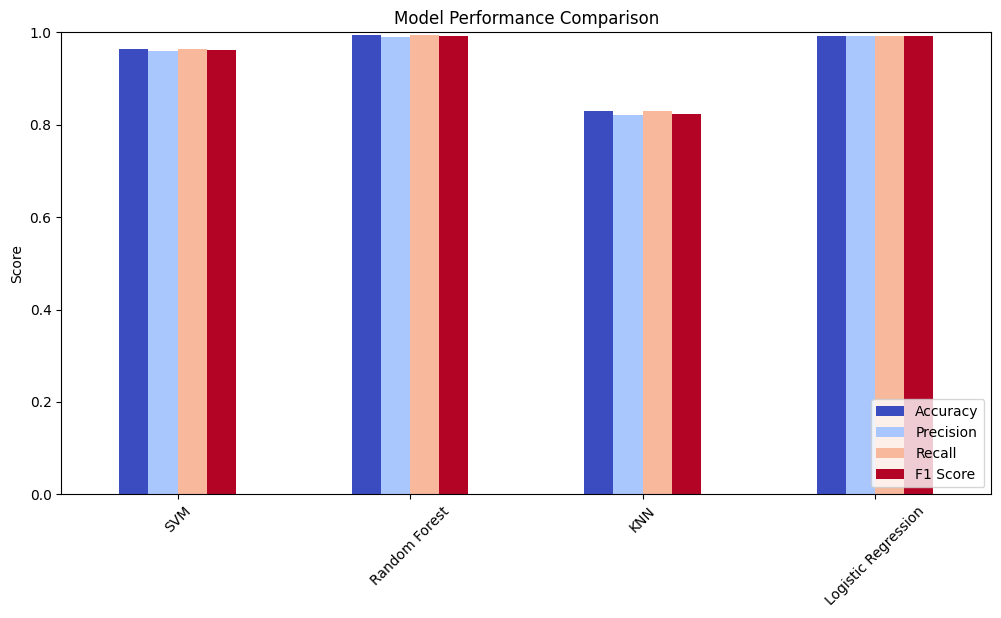

In [26]:
# 1. Model Performance Comparison (Bar Chart)
metrics_df = pd.DataFrame(results).T[['Accuracy', 'Precision', 'Recall', 'F1 Score']]
metrics_df.plot(kind='bar', figsize=(12, 6), colormap="coolwarm")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()

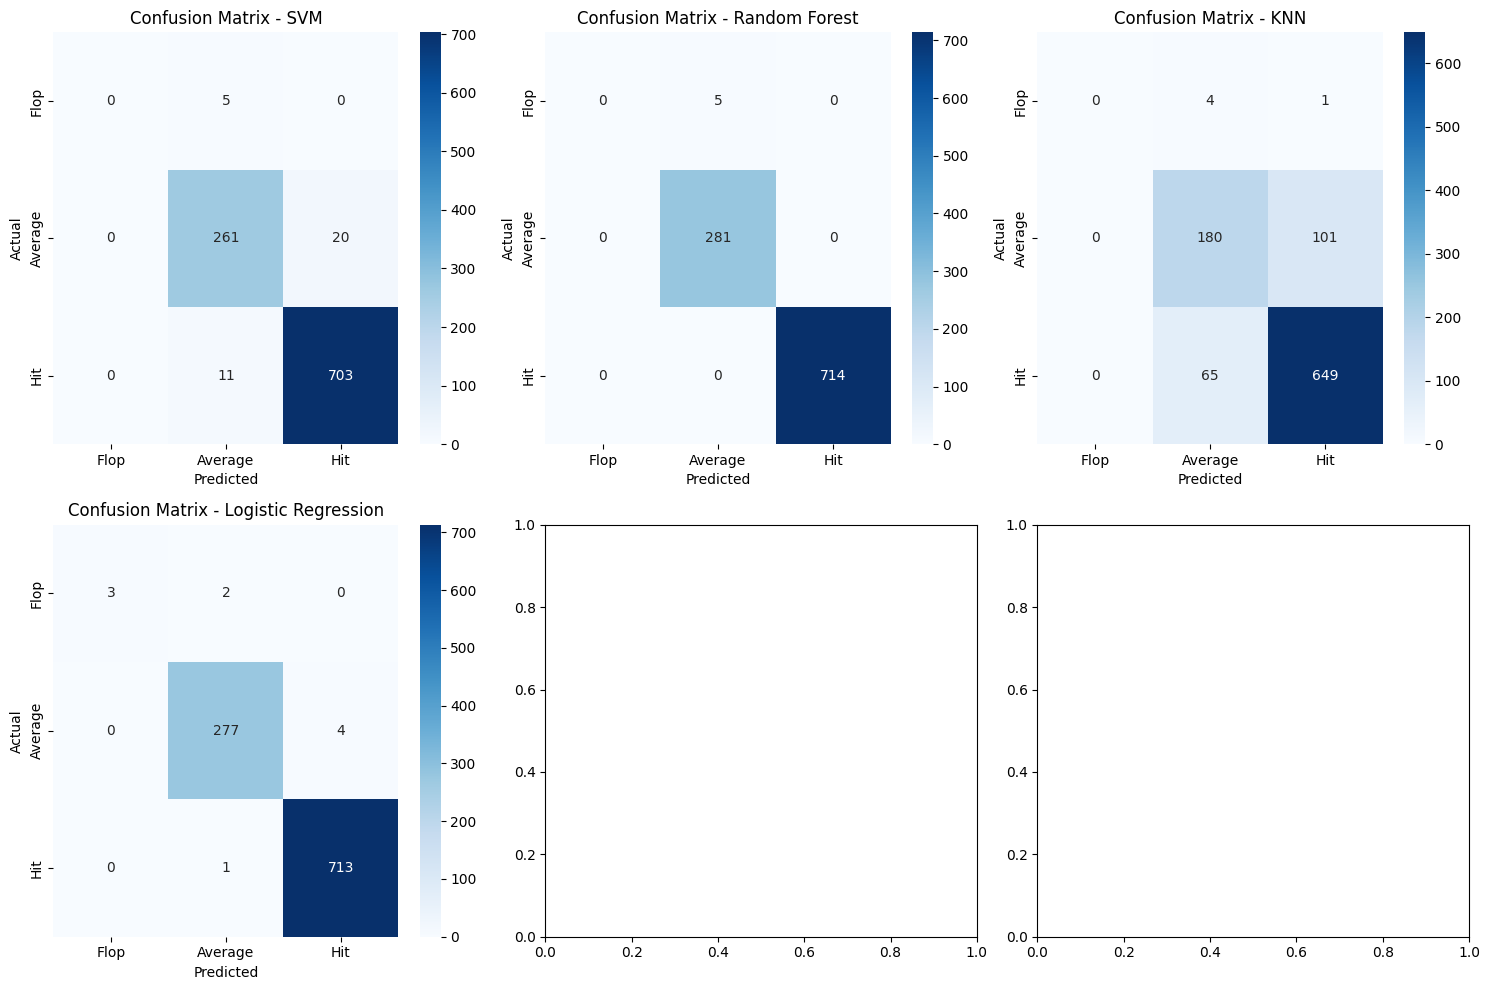

In [27]:
# 2. Confusion Matrices for All Models
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (model_name, metrics) in enumerate(results.items()):
    sns.heatmap(metrics["Confusion Matrix"], annot=True, fmt='d', cmap='Blues', 
                xticklabels=["Flop", "Average", "Hit"], yticklabels=["Flop", "Average", "Hit"], ax=axes[idx])
    axes[idx].set_title(f"Confusion Matrix - {model_name}")
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")

plt.tight_layout()
plt.show()